# Employee Retention

In this challenge, you have a data set with info about the employees and have to predict when
employees are going to quit by understanding the main drivers of employee churn

As said above, the goal is to predict employee retention and understand its main drivers.
Specifically, you should:
- Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate
employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13.
That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have
already quit, then company headcount on 2012/03/02 for company 1 would be 1000.
__You should create a table with 3 columns: day, employee_headcount, company_id.__
- What are the main factors that drive employee churn? Do they make sense? Explain your
findings.
- If you could add to this data set just one variable that could help explain employee churn,
what would that be?

Refer to [JIFU ZHAO](https://github.com/JifuZhao/DS-Take-Home/blob/master/03.%20Employee%20Retention.ipynb)

## Import libraries and data

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
import  warnings
warnings.simplefilter('ignore')
import graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

In [27]:
data = pd.read_csv('employee_retention_data.csv', parse_dates=['join_date', 'quit_date'])

In [28]:
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   employee_id  24702 non-null  float64       
 1   company_id   24702 non-null  int64         
 2   dept         24702 non-null  object        
 3   seniority    24702 non-null  int64         
 4   salary       24702 non-null  float64       
 5   join_date    24702 non-null  datetime64[ns]
 6   quit_date    13510 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 1.3+ MB


In [30]:
data.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


In [36]:
#Discover and visualize the data to gain insights
print('Variable', '   ', 'count of unique value','  ', 'content')
for column in data.columns:
    uniques = data[column].unique()
    print('{0:20s} {1:4d}\t'.format(column, len(uniques)), uniques[:2])

Variable     count of unique value    content
employee_id          24702	 [ 13021. 825355.]
company_id             12	 [7 4]
dept                    6	 ['customer_service' 'marketing']
seniority              31	 [28 20]
salary                367	 [ 89000. 183000.]
join_date             995	 ['2014-03-24T00:00:00.000000000' '2013-04-29T00:00:00.000000000']
quit_date             665	 ['2015-10-30T00:00:00.000000000' '2014-04-04T00:00:00.000000000']


## Create Table for day, employee_headcount, and company_id

In [32]:
# Define useful information
unique_date = pd.date_range(start='2011-01-24', end='2015-12-13', freq='D')
unique_company = sorted(data['company_id'].unique())

day = []
company = []
headcount = []

# Loop through date and company id
for date in unique_date:
    for idx in unique_company:
        total_join = len(data[(data['join_date'] <= date) & (data['company_id'] == idx)])
        total_quit = len(data[(data['quit_date'] <= date) & (data['company_id'] == idx)])
        day.append(date)
        company.append(idx)
        headcount.append(total_join - total_quit)

# Create table for day, employee_headcount, company_id
table = pd.DataFrame({'day': day, 'company_id': company, 'employee_headcount': headcount}, 
                     columns=['day', 'company_id', 'employee_headcount'])

In [33]:
table.head()

,day,company_id,employee_headcount
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5


## Q2: Factors that drive employee churn

In [34]:
# Separate stay and quit data
quit_data = data[~data['quit_date'].isnull()]
stay_data = data[data['quit_date'].isnull()]

In [35]:
quit_data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30


In [42]:
work_days

array([ 585,  340,  389, ...,  780, 1123,  864])

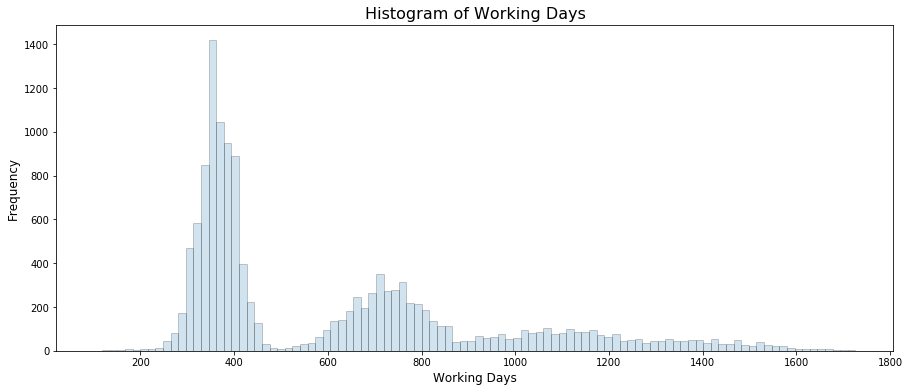

In [40]:
# Total working days
work_days = np.array(list(map(lambda x: x.days, quit_data['quit_date'] - quit_data['join_date'])))

hist_kws={'histtype': 'bar', 'edgecolor': 'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(15, 6))

sns.distplot(work_days, bins=100, kde=False, ax=ax, hist_kws=hist_kws)

ax.set_title('Histogram of Working Days', fontsize=16)
ax.set_xlabel('Working Days', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

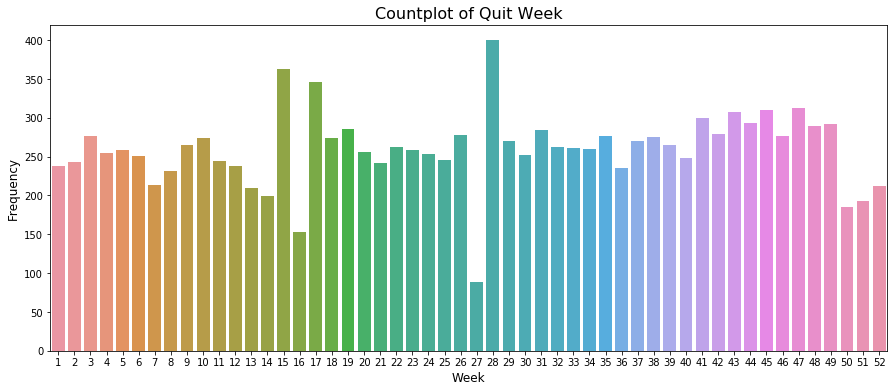

In [50]:
# Week No. for quiting
quit_week = np.array(list(map(lambda x: x.week, quit_data['quit_date'])))

fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(quit_week, ax=ax)
ax.set_title('Countplot of Quit Week', fontsize=16)
ax.set_xlabel('Week', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

In [49]:
# Choose quit data
quit_data['work_days'] = work_days
quit_data['quit_week'] = quit_week

quit_data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,work_days,quit_week
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340,2014-04-04
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040,2014-08-22
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,578,2013-08-30


## ML model: Decision Tree Model

In [51]:
# Choose the subset data
stop_date = pd.to_datetime('2015-12-13') - pd.DateOffset(days=365 + 31)
subset = data[data['join_date'] < stop_date]

# Binary label for early quit (less than 13 months)
quit = subset['quit_date'].isnull() | (subset['quit_date'] > subset['join_date'] + pd.DateOffset(days=396))
subset['quit'] = 1 - quit.astype(int)

subset.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,0


In [52]:
# # One-hot encoding
# # Two many company features, then chose label feature
# subset['company_id'] = subset['company_id'].astype(str)
# dummies = pd.get_dummies(subset[['company_id', 'dept']])
# train_x = pd.concat(objs=[subset[['seniority', 'salary']], dummies], axis=1)
# train_y = subset['quit'].values

# train_x.head()

In [53]:
# Label encoder
le = LabelEncoder()
train_x = subset[['company_id', 'seniority', 'salary']]
train_x['dept'] = le.fit_transform(subset['dept'])
train_y = subset['quit'].values

train_x.head()

,company_id,seniority,salary,dept
0,7,28,89000.0,0
1,7,20,183000.0,4
2,4,14,101000.0,4
3,7,20,115000.0,0
4,2,23,276000.0,1


In [54]:
# Build decision tree
clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=30, random_state=42)
clf = clf.fit(X=train_x, y=train_y)

In [55]:
# Visualization
features = list(train_x.columns)
targets = ['Not quit', 'Quit']
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=features, class_names=targets, 
                                filled=True, rounded=True, special_characters=True)

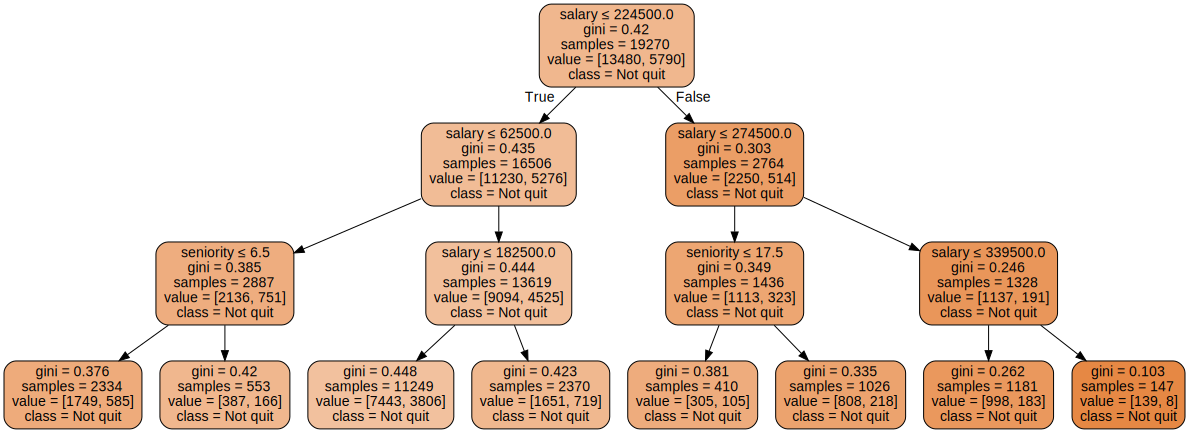

In [56]:
# Visualization
features = list(train_x.columns)
targets = ['Not quit', 'Quit']
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=features, class_names=targets, 
                                filled=True, rounded=True, special_characters=True, )  
graph = graphviz.Source(dot_data)
graph

In [57]:
# Feature importance
importance = sorted(zip(features, clf.feature_importances_), key=lambda x:x[1], reverse=True)
for feature, val in importance:
    print('{0:10s} | {1:.5f}'.format(feature, val))

salary     | 0.97439
seniority  | 0.02561
company_id | 0.00000
dept       | 0.00000


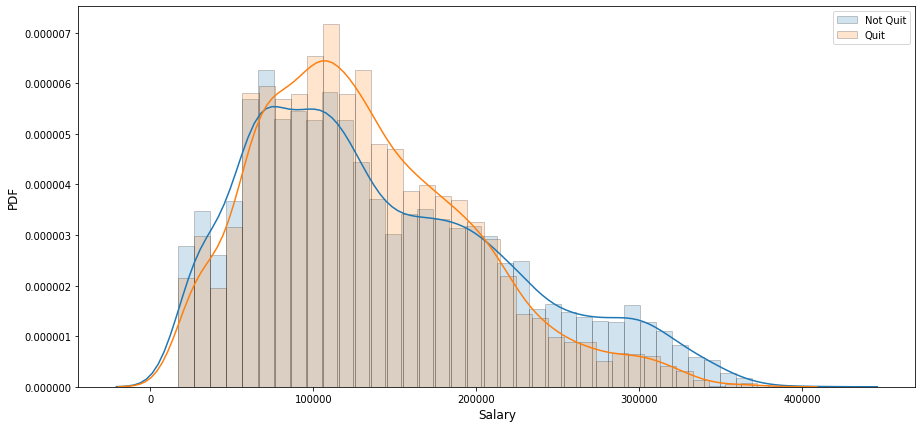

In [58]:
# Visualization
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(15, 7))
sns.distplot(subset[subset['quit']==0]['salary'], 
             label='Not Quit', ax=ax, hist_kws=hist_kws)
sns.distplot(subset[subset['quit']==1]['salary'], 
             label='Quit', ax=ax, hist_kws=hist_kws)
ax.set_xlabel('Salary', fontsize=12)
ax.set_ylabel('PDF', fontsize=12)
ax.legend()
plt.show()

### Add one variable to explain
#### Findings:

1. Given how important is salary, I would definitely love to have as a variable the salary the employee who quit was offered in the next job. Otherwise, things like: promotions or raises received during the employee tenure would be interesting.
2. The major findings are that employees quit at year anniversaries or at the beginning of the year. Both cases make sense. Even if you don’t like your current job, you often stay for 1 yr before quitting + you often get stocks after 1 yr so it makes sense to wait. Also, the beginning of the year is well known to be the best time to change job: companies are hiring more and you often want to stay until end of Dec to get the calendar year bonus.
3. There is high attrition during first year of employment. Employee appreciation programs targeted towards new employees will help reduce attrition.
4. Employees with low and high salaries are less likely to quit. Probably because employees with high salaries are happy there and employees with low salaries are not that marketable, so they have a hard time finding a new job.

If I could add one feature to the dataset, I would add employee satisfaction, as it might help explain the peaks/troughs in the quitting percentile. Then, I would add information about whether an employee is getting a bonus at the end of their year. This might explain why there is a large peak of people quitting after their first year, and then a second peak after their second year. With the information on whether they get a bonus, it might explain why there are some employees who quit after their second year instead of after their first (if they don't get a bonus the first year).